# Machine Learning 2023-2024 - UMONS

# Classification

In this lab we'll experiment with multiclass classification. We'll consider several models, some of which will be covered later in the course.
We'll be using the [Wine Quality](https://archive.ics.uci.edu/ml/datasets/wine+quality) dataset, which contains several attributes of white wines.
Each observation is associated to a rating between 0 and 10 that will be the label of our classification task.

The columns of the dataframe contain the following information :
* fixed_acidity: amount of tartaric acid in g/dm^3
* volatile_acidity: amount of acetic acid in g/dm^3 
* citric_acid: amount of citric acid in g/dm^3
* residual_sugar: amount of remaining sugar after fermentation stops in g/l
* chlorides: amount of salt in wine 
* free_sulfur_dioxide: amount of free SO2
* total_sulfur_dioxide: amount of free and bound forms of SO2
* density: density of the wine
* pH: PH level of the wine on a scale from 0 to 14
* sulphates: amount of sulphates 
* alcohol: the percent of alcohol content
* quality: quality of the wine (score between 0 and 10)

**Import the necessary libraries**

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             confusion_matrix, log_loss, classification_report)
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, LabelBinarizer
import warnings

np.random.seed(0)

**We load the dataset 'wine.csv'.**

In [2]:
df = pd.read_csv('data/wine.csv', sep=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


**1) Check the properties of this dataset (length, types, missing values).** 

In [3]:
print(df.shape)
print(df.dtypes)
print(df.isna().sum())

(4898, 12)
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


## Data splitting

**We predict the target 'quality' from all other features. We split the dataset into a training and test set following a 80/20 partition.**

In [4]:
ylabel = 'quality'
X = df.drop(ylabel, axis=1)
y = df[ylabel]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, test_size=0.2, shuffle=True, random_state=0
)

## Data exploration

**2) Look at the distribution of the variable 'quality' in the training set using `sns.countplot`.**

<Axes: xlabel='quality', ylabel='count'>

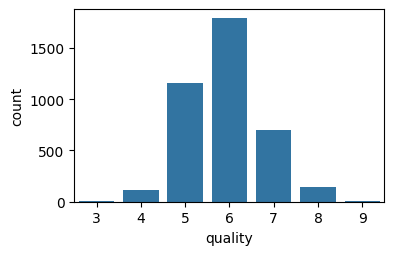

In [5]:
fig = plt.figure(figsize=(4, 2.5))
sns.countplot(x=y_train)

**3) For each continuous feature, plot a boxplot of this feature grouped by label values. Use the `sns.boxenplot` function of the seaborn library. Which features seem to be the most useful to predict the label 'quality'?**

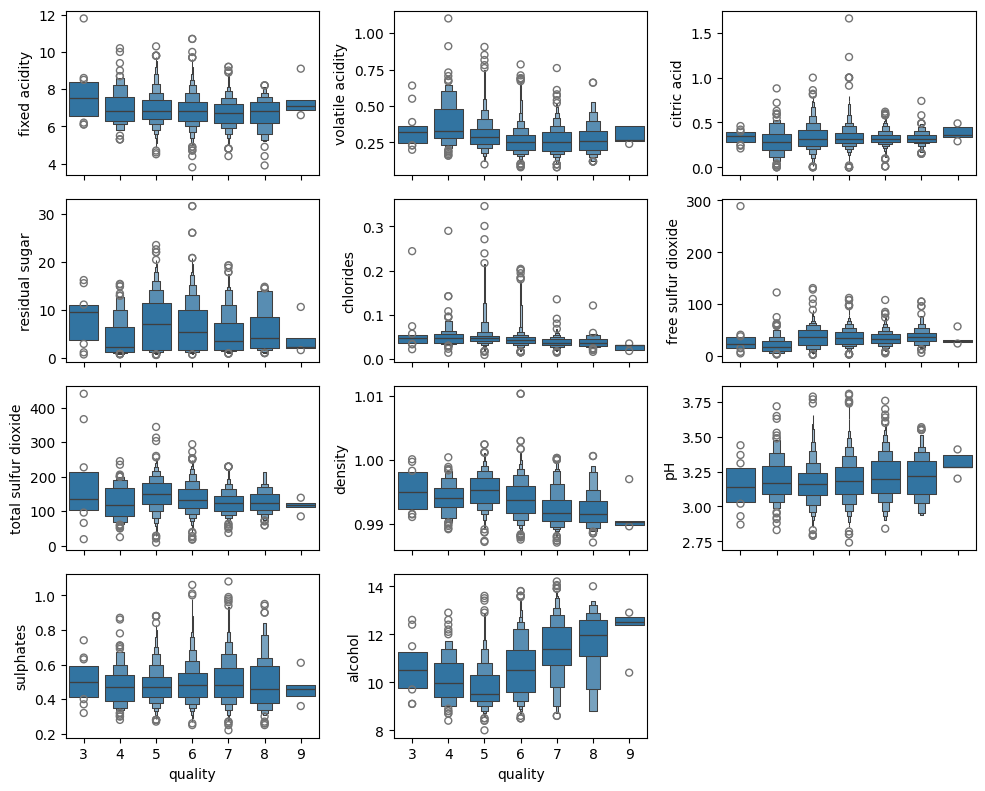

In [6]:
fig, axes = plt.subplots(4, 3, figsize=(10, 8), sharex=True)
axes = axes.flatten()
for column, axis in zip(X_train.columns, axes):
    sns.boxenplot(x=y_train, y=X_train[column], ax=axis)
axes[-1].set_visible(False)
fig.tight_layout()

Based on the boxplots, alcohol, density and pH seem to be the most useful features.

**4) Plot the pairwise relationship of the most useful features using the function `sns.pairplot`. Plot a different color according to the value of the variable 'quality' using the `hue` parameter. What do you observe?**

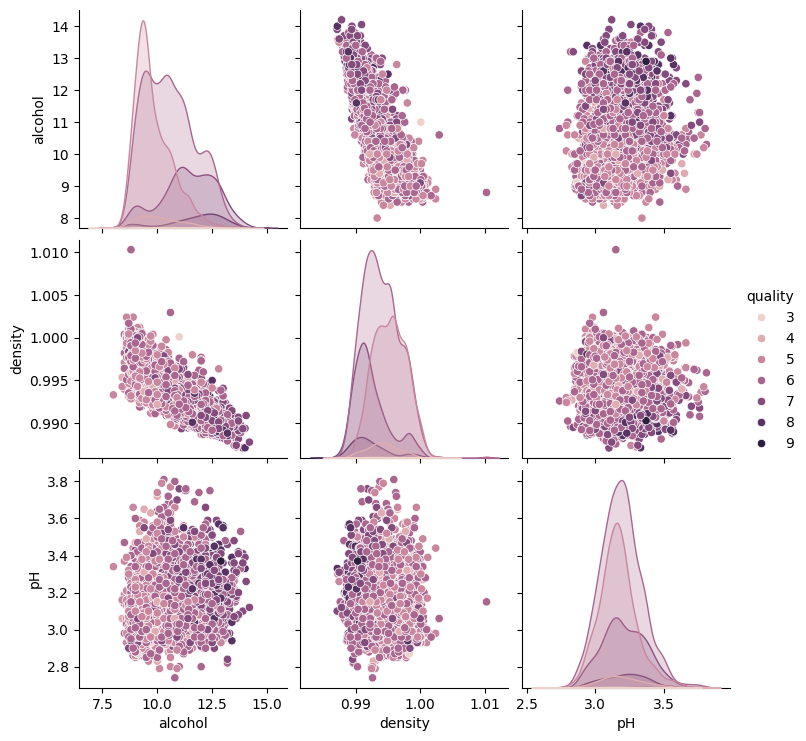

In [7]:
sns.pairplot(pd.concat([X_train[['alcohol', 'density', 'pH']], y_train], axis=1), hue='quality')

We notice that there is a negative correlation between the variables alcohol and density. There does not seem to be a clear correlation between the other variables.

## Classification metrics

**5) Define a simple pipeline where you first scale the data with `StandardScaler` to have zero mean and unit variance followed by a (linear) logistic regression. Then fit the model.**

In [8]:
model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

**6) One of the most useful tool to diagnose a classification model is the confusion matrix. Print it using `confusion_matrix` and `ConfusionMatrixDisplay`.**

The size of the matrix is $n \times n$, where $n$ is the number of classes. Each row represents the instances in an actual class, while each column represents the instances in a predicted class. A cell $i, j$ represents the number of instances of class $i$ that were predicted as class $j$.

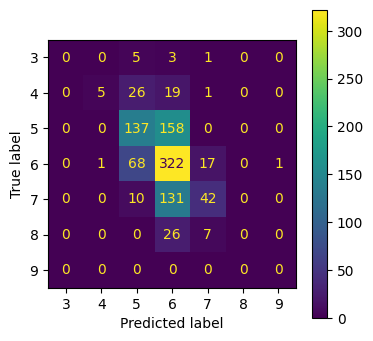

In [9]:
fig, ax = plt.subplots(figsize=(4, 4))
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(ax=ax);

**7) From the confusion matrix, several performance metrics can be calculated for each class, as well as overall metrics. Using the function `classification_report`, generate a report of these different metrics. Use the argument `zero_division=0` to avoid warnings.**

Here's what each of these terms represents:

1. **Precision**: This is the ratio of correctly predicted positive observations to the total predicted positives. It is an indicator of the accuracy of the positive predictions. For class $i$, precision is calculated as:
   $$
   \text{Precision}_i = \frac{TP_i}{TP_i + FP_i}
   $$
   where $TP_i$ are the true positives and $FP_i$ are the false positives for class $i$.

2. **Recall** (also known as Sensitivity or True Positive Rate): This is the ratio of correctly predicted positive observations to all observations in the actual class. It shows how well the model can find all the positive samples. For class $i$, recall is calculated as:
   $$
   \text{Recall}_i = \frac{TP_i}{TP_i + FN_i}
   $$
   where $FN_i$ are the false negatives for class $i$.

3. **F1-Score**: This is the harmonic mean of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. It is particularly useful when the class distribution is uneven. F1-score is calculated as:
   $$
   \text{F1-Score}_i = \frac{2}{\frac{1}{\text{Precision}_i} + \frac{1}{\text{Recall}_i}} = 2 \times \frac{\text{Precision}_i \times \text{Recall}_i}{\text{Precision}_i + \text{Recall}_i}
   $$

4. **Support**: This is the number of actual occurrences of the class in the specified dataset. It doesn’t reflect the model’s performance but is very useful for determining the significance of the classification metrics.

These metrics can be averaged to obtain:
- **Macro average**: This is the average of the precision, recall, and f1-score without taking class imbalance into account. It treats all classes equally, regardless of their support.
- **Weighted average**: This averages the precision, recall, and f1-score, with weighting by support for each class. This means that the influence of each class's score on the overall average is proportional to the number of instances of that class.

In [10]:
print(classification_report(y_test, y_pred, labels=model.classes_, zero_division=0))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         9
           4       0.83      0.10      0.18        51
           5       0.56      0.46      0.51       295
           6       0.49      0.79      0.60       409
           7       0.62      0.23      0.33       183
           8       0.00      0.00      0.00        33
           9       0.00      0.00      0.00         0

    accuracy                           0.52       980
   macro avg       0.36      0.23      0.23       980
weighted avg       0.53      0.52      0.48       980



### The log loss

The log loss for a multiclass classification model is calculated as follows:
$$
\text{Log Loss} = -\frac{1}{n} \sum_{i=1}^{n} \sum_{k=1}^{K} y_{ik} \log(p_{ik})
$$
where:
- $n$ is the total number of observations.
- $K$ is the number of classes.
- $y_{ik}$ is a binary indicator (0 or 1) if class label $k$ is the correct classification for observation $i$.
- $p_{ik}$ is the predicted probability that observation $i$ belongs to class $k$.

Remember from the course that $\argmin_{\theta \in \Theta} \mathbb{E}[-\log p(Y; \theta)] = \argmin_{\theta \in \Theta} \text{KL}(p_\theta, p)$.
Since the distribution that minimizes the KL divergence is the true distribution, the expectation of the log loss will be minimized when the model always predicts the correct vector of probabilities.

**8) Predict probabilities using the `predict_proba` method of the logistic regression model. Then calculate the log loss using the `log_loss` function.**

In [11]:
y_pred_proba = model.predict_proba(X_test)
log_loss(y_test, y_pred_proba, labels=model.classes_)

1.1815807853349691

**9) Based on `y_test_binarized`, compute the log loss manually and check that it corresponds to the previous log loss.**

In [12]:
lb = LabelBinarizer()
lb.fit(y_train)
y_test_binarized = lb.transform(y_test)

In [13]:
-(y_test_binarized * np.log(y_pred_proba)).sum(axis=1).mean()

1.1815807853349691

## Hyperparameter tuning

**10) We will now experiment with various models for classification. For each one of the following models, design a grid of hyperparameters based on the corresponding scikit-learn documentation:**
- **[KNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)**
- **[Gaussian Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)**
- **[Linear Discriminant Analysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html)**
- **[Quadratic Discriminant Analysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html)**
- **[Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)**
- **[Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)**
- **[Gradient Boosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)**

In [14]:
param_grid_knn = {
    'clf__n_neighbors': [3, 5, 10, 20, 50, 100],
    'clf__weights': ['uniform', 'distance'],
    'clf__p': [1, 2],
}

param_grid_nb = {}

param_grid_lda = {}

param_grid_qda = {
    'clf__reg_param': [0, 0.1, 0.5, 1],
} 

param_grid_lr = {
    'clf__penalty': ['l2'],
    'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'clf__fit_intercept': [True, False],
}

# We additionally experiment with a logistic regression model with feature selection
param_grid_lr_skb = {
    'skb__k': [3, 5, 7, 9],
    'clf__penalty': ['l2'],
    'clf__fit_intercept': [True, False],
}

param_grid_rf = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 2, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_gb = {
    'loss': ['log_loss'],
    'learning_rate': [0.02, 0.1, 0.5],
    'n_estimators': [100, 200, 300],
    'criterion': ['friedman_mse', 'squared_error'],
    'max_depth': [None, 2, 5, 10],
}

## Model fitting

**11) For each one of these models, select the hyperparameters that give the lowest log loss using the `RandomizedSearchCV` class. Don't forget to normalize the data if necessary. Compute the accuracy and log loss on the test dataset for the best hyperparameters.**

**Print the best hyperparameters corresponding to each model and plot a confusion matrix.**

Running KNN


Accuracy: 0.645
Log loss: 1.288
Best hyperparameters: {'clf__weights': 'distance', 'clf__p': 2, 'clf__n_neighbors': 100}


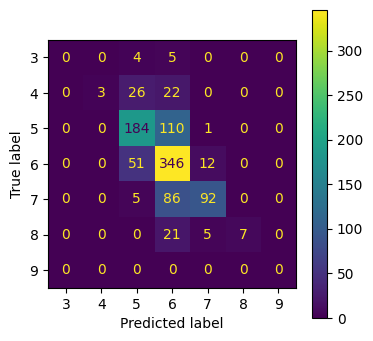

Running Naive Bayes
Accuracy: 0.442
Log loss: 1.732
Best hyperparameters: {}


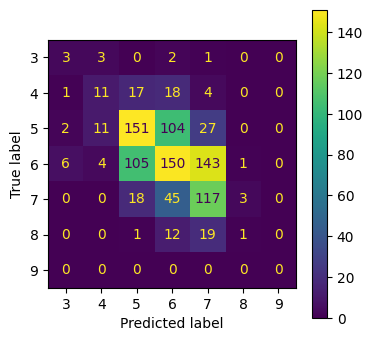

Running Linear Discriminant Analysis
Accuracy: 0.509
Log loss: 1.235
Best hyperparameters: {}


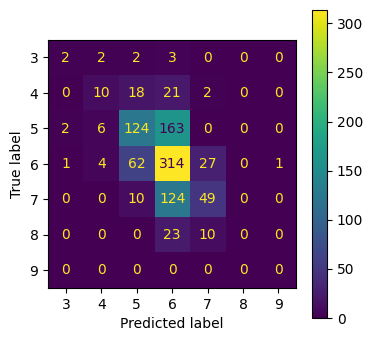

Running Quadratic Discriminant Analysis
Accuracy: 0.509
Log loss: 1.235
Best hyperparameters: {}


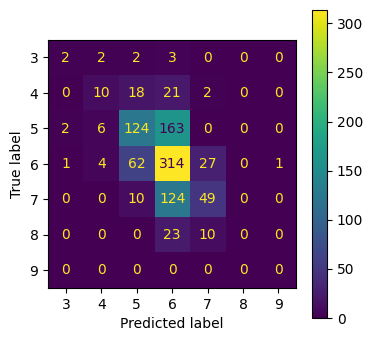

Running Logistic Regression
Accuracy: 0.508
Log loss: 1.174
Best hyperparameters: {'clf__penalty': 'l2', 'clf__fit_intercept': True, 'clf__C': 0.1}


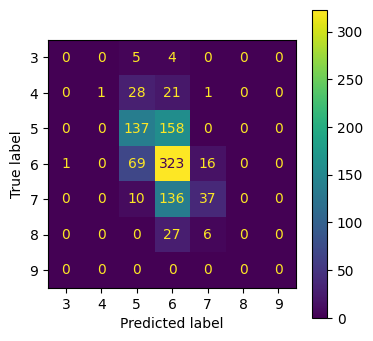

Running Logistic Regression with feature selection
Accuracy: 0.496
Log loss: 1.188
Best hyperparameters: {'skb__k': 9, 'clf__penalty': 'l2', 'clf__fit_intercept': True}


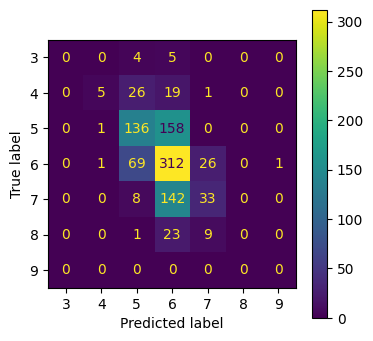

Running Random Forest
Accuracy: 0.657
Log loss: 0.958
Best hyperparameters: {'clf__n_estimators': 300, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 1, 'clf__max_depth': None, 'clf__criterion': 'log_loss'}


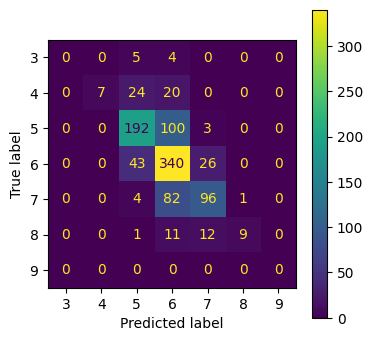

Running Gradient Boosting
Accuracy: 0.644
Log loss: 1.049
Best hyperparameters: {'clf__n_estimators': 100, 'clf__max_depth': 10, 'clf__loss': 'log_loss', 'clf__learning_rate': 0.02, 'clf__criterion': 'friedman_mse'}


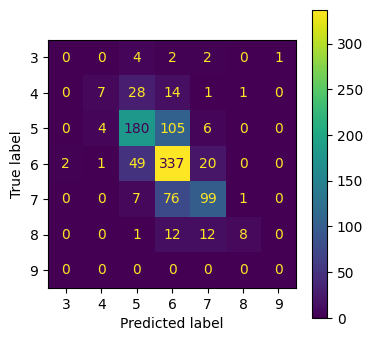

In [15]:
knn = KNeighborsClassifier()
nb = GaussianNB()
lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()
lr = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()

preprocessor = StandardScaler()
knn = Pipeline([('pre', preprocessor), ('clf', knn)])
nb = Pipeline([('pre', preprocessor), ('clf', nb)])
lda = Pipeline([('pre', preprocessor), ('clf', lda)])
qda = Pipeline([('pre', preprocessor), ('clf', qda)])
lr = Pipeline([('pre', preprocessor), ('clf', lr)])
lr_skb = Pipeline([('pre', preprocessor), ('skb', SelectKBest()), ('clf', LogisticRegression(max_iter=1000))])

default_grid_params = dict(n_iter=10, cv=5, n_jobs=4)

grids = {
    'KNN': RandomizedSearchCV(knn, param_grid_knn, scoring='neg_log_loss', **default_grid_params),
    'Naive Bayes': RandomizedSearchCV(nb, param_grid_nb, scoring='neg_log_loss', **default_grid_params),
    'Linear Discriminant Analysis': RandomizedSearchCV(lda, param_grid_lda, scoring='neg_log_loss', **default_grid_params),
    'Quadratic Discriminant Analysis': RandomizedSearchCV(lda, param_grid_lda, scoring='neg_log_loss', **default_grid_params),
    'Logistic Regression': RandomizedSearchCV(lr, param_grid_lr, scoring='neg_log_loss', **default_grid_params),
    'Logistic Regression with feature selection': RandomizedSearchCV(lr_skb, param_grid_lr_skb, scoring='neg_log_loss', **default_grid_params),
    'Random Forest': RandomizedSearchCV(rf, param_grid_rf, scoring='neg_log_loss', **default_grid_params),
    'Gradient Boosting': RandomizedSearchCV(gb, param_grid_gb, scoring='neg_log_loss', **default_grid_params),
}

results = []
for model_name, model in grids.items():
    print('Running', model_name)
    # Note that by default the argument `refit` of `RandomizedSearchCV` is set to True, so that the best estimator 
    # is refit on the whole training set.
    model.fit(X_train, y_train)

    # We measure the test accuracy and log score.
    y_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {test_accuracy:.3f}')

    y_pred_proba = model.predict_proba(X_test)
    test_log_loss = log_loss(y_test, y_pred_proba, labels=model.classes_)
    print(f'Log loss: {test_log_loss:.3f}')

    results.append([test_accuracy, test_log_loss])
    
    print(f'Best hyperparameters: {model.best_params_}')

    # We plot the confusion matrix
    fig, ax = plt.subplots(figsize=(4, 4))
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(ax=ax)
    plt.show()

**12) Create a pandas dataframe where each row corresponds to a model. The columns should correspond to the accuracy and log loss.**

In [16]:
pd.DataFrame(results, columns=['Test accuracy', 'Test log loss'], index=grids.keys())

,Test accuracy,Test log loss
KNN,0.644898,1.288200
Naive Bayes,0.441837,1.731673
Linear Discriminant Analysis,0.509184,1.234705
Quadratic Discriminant Analysis,0.509184,1.234705
Logistic Regression,0.508163,1.173853
Logistic Regression with feature selection,0.495918,1.188181
Random Forest,0.657143,0.958139
Gradient Boosting,0.643878,1.049220


We observe that Random Forest, Gradient Boosting, and KNN obtain the best accuracy.
Random Forest and Gradient Boosting obtain the best log score.
Note that, on this dataset, KNN has a good accuracy, but its probabilistic predictions are quite poor, as indicated by the log loss.